# Исследование стартапа

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуем результаты A/A/B-эксперимента. 

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста.  Выясним, какой шрифт лучше.

### Откроем файл с данными

In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import math as mth
from plotly import graph_objects as go
from scipy import stats as st

# Загружаем необходимые библиотеки

In [54]:
pd.set_option('display.max_colwidth', None)
# снимаем ограничение на ширину столбцов

In [55]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
# открываем файл, дав название

In [56]:
data.head(5)
# проверяем

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Подготовим данные

In [57]:
data.info()
# смотрим общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [58]:
data.isna().sum()
# проверяем таблицу на наличие пропусков

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [7]:
data.duplicated().sum()
# проверяем наличие дубликатов

413

In [59]:
data = data.drop_duplicates().reset_index(drop=True)
# удаляем дубликаты

In [60]:
data.duplicated().sum()
# проверяем

0

In [61]:
data = data.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp':'event_time' 
                              , 'ExpId': 'group'})
# переименовываем столбцы

In [62]:
data.head(2) # проверяем

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


In [63]:
data['event_time'] = pd.to_datetime(data.event_time, unit='s')
# приведем столбец event_time к "читаемому"

In [64]:
data["event_date"] = data.event_time.dt.date
# добавим столбец даты

In [65]:
data
# проверяем

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


Открыли таблицу, удалили дубликаты, так как они составляют менне 0.5% данных. Переименовали названия столбцов под удобные. Перевели формат времени и формата ISO. Добавили отдельный столбец с датой события

In [15]:
trio = data.groupby(['user_id']).agg({"group": "nunique"}).reset_index()
print('Пользователей, которые вошли в две либо в три группы, их всего:', trio[trio.group!=1]["user_id"].count())

Пользователей, которые вошли в две либо в три группы, их всего: 0


### Изучим и проверим данные

In [66]:
print("Всего в логе", data["event_name"].count(), "событий. Из них уникальных:", data["event_name"].nunique())

Всего в логе 243713 событий. Из них уникальных: 5


In [67]:
print("Уникальные события:")
data["event_name"].value_counts()

Уникальные события:


MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [68]:
print("Количество уникальных пользователей:", data['user_id'].nunique())

Количество уникальных пользователей: 7551


In [69]:
print("В среднем на одного пользователя приходится около", 
        (data["event_name"].count()/ data['user_id'].nunique()).round(2), "событий")

В среднем на одного пользователя приходится около 32.28 событий


In [71]:
print("Начальная дата", data["event_time"].min(),"конечная дата", data["event_time"].max())
print("Общий период составляет", data["event_time"].max()- data["event_time"].min())
# определяем начальную и конечную даты и период

Начальная дата 2019-07-25 04:43:36 конечная дата 2019-08-07 21:15:17
Общий период составляет 13 days 16:31:41


Text(0, 0.5, 'Количество событий')

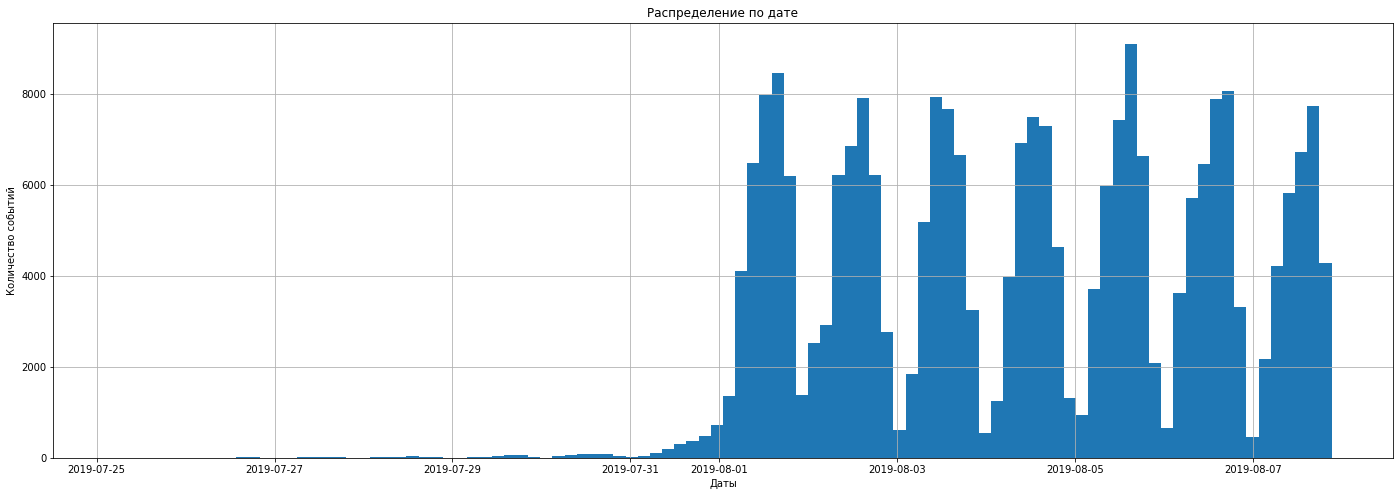

In [72]:
ax = data['event_time'].hist(bins=100, figsize=(24, 8))
plt.title("Распределение по дате")
plt.xlabel("Даты")
plt.ylabel("Количество событий")

Судя по графику до 1 августа практически никакой активности, соответственно можно откинуть данные за июль

In [73]:
august_data = data.loc[data["event_time"] > "2019-08-01 00:00:00"]
# выделяем только август

In [74]:
august_data.head(5)
# проверяем

,event_name,user_id,event_time,group,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [75]:
print("В обновленной таблице осталось", august_data["event_name"].count(), "событий. Мы потеряли всего",
      data["event_name"].count()- august_data["event_name"].count(), "событий. Что составляет всего около", 
      ((data["event_name"].count()- august_data["event_name"].count())/data["event_name"].count()*100).round(), "%" )

В обновленной таблице осталось 240887 событий. Мы потеряли всего 2826 событий. Что составляет всего около 1.0 %


In [76]:
print ("В старой базе было", data['user_id'].nunique(), "пользователь. В новой на",
       data['user_id'].nunique() - august_data['user_id'].nunique() , "меньше")

В старой базе было 7551 пользователь. В новой на 17 меньше


In [77]:
august_data['group'].value_counts()
# проверяем пользователей во всех группах

248    84563
246    79302
247    77022
Name: group, dtype: int64

In [78]:
august_data.groupby("group")["user_id"].nunique()
# проверяем распределение пользователй по группам

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Вывод. Во второй неделе эксперемента осталось 99% пользователей. Группы примерно равны по объему

### Изучим воронку событий.

In [79]:
august_data["event_name"].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Отображается главный экран 117328

Отображается экран предложений 46333

Отображается экран корзины 42303

Экран успешной оплаты 33918

Руководство 1005

Руководство встречается довольно редко, это по всей видимости связано с тем, что интерфейс мобильного приложения интуитивно понятен подавляющему большинству пользователей.

In [80]:
users_event_count = august_data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()  
# сгруппируем и посчитаем сколько пользователей совершали те или иные действия

In [81]:
users_event_count
# проверяем

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [82]:
users_event_count['percent'] = (users_event_count['user_id']/ august_data["user_id"].nunique()*100).round(2)
# добавляем столбец с долей пользователей в процентах, совершивших событие 

In [83]:
users_event_count
# проверяем

,event_name,user_id,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Предположим, что события происходят в таком порядке: 
- Отображается главный экран 
- Отображается экран предложений 
- Отображается экран корзины 
- Экран успешной оплаты. 
Руководство открывает очень маленькое количество людей, так как интерфейс, скорее всего, интуитивно понятен. Судя по тому, что на главный экран заходит не 100% пользователй, то по всей видимости, часть клиентов переходит сразу на экран отображения предложений по ссылке


In [84]:
users_event_count["funnel"] =( users_event_count ["user_id"] / users_event_count ["user_id"] .values[0]*100).round(2)
# определяем процент перешедших на следующую ступень

In [85]:
users_event_count
# проверяем

,event_name,user_id,percent,funnel
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,50.33
3,PaymentScreenSuccessful,3539,46.97,47.70
4,Tutorial,840,11.15,11.32


По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки. Больше всего пользователей теряется и не переходит с главного экрана на следующий - экран предложений (каталог). На следующих этапах теряется намного меньше и до покупки доходит 47% пользователей

In [86]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = users_event_count['event_name'],
    x = users_event_count['user_id']))
fig.update_layout(title_text='Воронка событий')
fig.show()

### Изучим результаты эксперимента

In [87]:
august_data.groupby("group")["user_id"].nunique()
# проверяем сколько пользователей во всех группах

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Разница в группах минимальна, поэтому будем считать, что группы равны

In [88]:
all_events = (august_data.groupby(['event_name', 'group']).agg({'user_id': 'nunique'}).
          reset_index().sort_values(by=['user_id', 'event_name' ], ascending=False))
# отсортируем по событиям

In [89]:
all_events
#  проверяем

,event_name,group,user_id
5,MainScreenAppear,248,2493
4,MainScreenAppear,247,2476
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542
8,OffersScreenAppear,248,1531
7,OffersScreenAppear,247,1520
0,CartScreenAppear,246,1266
1,CartScreenAppear,247,1238
2,CartScreenAppear,248,1230
9,PaymentScreenSuccessful,246,1200


In [90]:
august_norm_data = august_data.query('event_name != "Tutorial"')
august_norm_data = august_norm_data.groupby('group')['user_id'].nunique()
august_norm_data
# уберем tutorial из событий

group
246    2483
247    2512
248    2535
Name: user_id, dtype: int64

In [91]:
august_norm_data.loc['246+247'] =  4995
# добавим объединенную группу

In [92]:
august_norm_data
# проверим

group
246        2483
247        2512
248        2535
246+247    4995
Name: user_id, dtype: int64

In [93]:
people = august_data.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
# создаем таблицу с разбивкой по группам
people['246+247'] = people[246] + people[247]
# добавляем столбец с объединенными данными

In [94]:
people
# проеверяем

group,event_name,246,247,248,246+247
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


In [95]:
people = people.drop([4])
# удаляем Tutorial

In [96]:
people
# проверяем

group,event_name,246,247,248,246+247
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [97]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = '246',
    y = all_events.query('group == 246')['event_name'],
    x = all_events.query('group == 246')['user_id'],        
    textinfo = 'value + percent previous'))

fig.add_trace(go.Funnel(name = '247',
    y = all_events.query('group == 247')['event_name'],
    x = all_events.query('group == 247')['user_id'],        
    textinfo = 'value + percent previous'))

fig.add_trace(go.Funnel(name = '248',
    y = all_events.query('group == 248')['event_name'],
    x = all_events.query('group == 248')['user_id'],       
    textinfo = 'value + percent previous'))

fig.update_layout(title_text = 'Воронка событий по группам')
fig.show()

Существенной разницы между группами нет, в пределах 1-2 %

Зададим гипотезы и проверим:

H0: Разницы между группами от первого до последнего шага НЕТ

H1: Разница между группами от первого до последнего шага ЕСТЬ

In [98]:
alpha = 0.05 # критический уровень статистической значимости

pay = np.array([1200, 1158])
main = np.array([2450, 2476])

# пропорция успехов в первой группе:
p1 = pay[0]/main[0]

# пропорция успехов во второй группе:
p2 = pay[1]/main[1]

# пропорция успехов в комбинированном датасете:
p_combined = (pay[0] + pay[1]) / (main[0] + main[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / main[0] + 1 /main[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

# тест двухсторонний
p_value = (1 - distr.cdf(abs(z_value))) * 2



print('p-значение: ', p_value)
if p_value < alpha :
    print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
    )

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Тест подтвержлает, что нет разницы между группами

In [99]:
# напишем функцию
def z_test(gr1, gr2,  alpha): 
    p1_event = people.loc[event_name, gr1]
    p2_event = people.loc[event_name, gr2] 
    p1_users = august_norm_data.loc[gr1] 
    p2_users = august_norm_data.loc[gr2] 
    
    # пропорция успехов в первой группе:
    p1 = p1_event / p1_users 
    # пропорция успехов во второй группе
    p2 = p2_event / p2_users 
    
    # пропорция успехов в комбинированном датасете
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    # тест двухсторонний
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Cобытие: {}'.format(event_name))
    print('p-значение: ', p_value)
    
    bonferroni_alpha = alpha / 17  # произведено 17 сравнений
    
    if p_value < bonferroni_alpha:
        print("Отвергаем нулевую гипотезу о равенстве данных в группах")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")


H0: Различий в долях пользователей на каждом этапе воронки в группах 246 и 247  НЕТ

H1: Различия в долях пользователей на каждом этапе воронки в группах 246 и 247  ЕСТЬ

In [100]:
for event_name in people.index:
    z_test(246, 247, 0.05)
    print()

Cобытие: 0
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 1
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 2
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 3
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Видим, что различий в долях пользователей между группами 246 и 247 нет

H0: Различий в долях пользователей на каждом этапе воронки в группах 247 и 248  НЕТ

H1: Различия в долях пользователей на каждом этапе воронки в группах 247 и 248  ЕСТЬ

In [101]:
for event_name in people.index:
    z_test(247, 248, 0.05)
    print()

Cобытие: 0
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 1
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 2
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 3
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Видим, что различий в долях пользователей между группами 247 и 248(с измененным шрифтом) нет

H0: Различий в долях пользователей на каждом этапе воронки в группах 246 и 248  НЕТ

H1: Различия в долях пользователей на каждом этапе воронки в группах 246 и 248  ЕСТЬ

In [102]:
for event_name in people.index:
    z_test(246, 248, 0.05)
    print()

Cобытие: 0
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 1
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 2
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 3
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Видим, что различий в долях пользователей между группами 246 и 248(с измененным шрифтом) нет

H0: Различий в долях пользователей на каждом этапе воронки в объединенных группах 246 с 247 и 248  НЕТ

H1: Различия в долях пользователей на каждом этапе воронки в объединенных группах 246 с 247 и 248  ЕСТЬ

In [103]:
for event_name in people.index:
    z_test("246+247", 248, 0.05)
    print()

Cобытие: 0
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 1
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 2
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Cобытие: 3
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Видим, что различий между объединенными группами 246 и 247 и 248 (с измененным шрифтом)нет

### Общий вывод

В результате исследования были проанализированы действия пользователей мобильного приложения за период с  25 июля по 07 августа. В данном стартапе была предложена идея по смене шрифта в мобильном приложении, реализация днной идеи планировалась после провдения A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 
На стадии предобработки данных мы удалили незначительное количество дубликатов, поменяли формат времени,  переименовли названия столбцов, добавили новые. При исследовании сделали вывод о том, что за первую неделю не было практически никаких событий, поэтому дл исследования использовался период с 01 августа. Группы польователй практически равны около 2500 человек. Пользователи проходят 4 этапа Попадание на главный экран, экран предложений, экран корзины, экран оплаты. Есть еще экран с руководством, но на данную страницу мало кто заходит, что связано, по всей идимости, с тем, что интерфейс мобильного прилжения интуитивно понятен и необходимости в инструкциях у большинства пользователй нет. Поэтапно с главного экрана до успешной оплаты доходит чуть менее 50% пользователей. Также очень много пользователей теряется на этапе перехода с главного экрана на экран выбора товара (39%) На последующих этапах потерь немного. Соответсвенно можно сделать вывод, что с интерфейсом главного экрана что-то не то, что не дает возможности перехода на следующий этап. При исследовании данных и проведении тестов мы исключили этап "Руководство", так как онсамый непосещаемый.
При проведении тестов p-value мы взяли 0.05, что позволило сделать вывод о том, что  нет статистически значимой разницы между группами. Таким образом, внедерение обновленного шрифта в мобильное приложение не изменит поведение пользователей 